In [1]:
%conda install pandas

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.10.3
  latest version: 24.5.0

Please update conda by running

    $ conda update -n base conda



## Package Plan ##

  environment location: /home/studio-lab-user/.conda/envs/default

  added / updated specs:
    - pandas


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2024.7.4   |       hbcca054_0         151 KB  conda-forge
    certifi-2024.7.4           |     pyhd8ed1ab_0         156 KB  conda-forge
    libblas-3.9.0              |       8_openblas          11 KB  conda-forge
    libcblas-3.9.0             |       8_openblas          11 KB  conda-forge
    libgfortran-ng-7.5.0       |      h14aa051_20          23 KB  conda-forge
    libgfortran4-7.5.0         |      h14aa051_20         1.2 MB  conda-forge
    liblapack-3.9.0            |       8_openblas          11 K

In [3]:
%conda install geopandas

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.10.3
  latest version: 24.5.0

Please update conda by running

    $ conda update -n base conda



## Package Plan ##

  environment location: /home/studio-lab-user/.conda/envs/default

  added / updated specs:
    - geopandas


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    aws-c-auth-0.7.22          |       heee8711_7         104 KB  conda-forge
    aws-c-cal-0.7.0            |       h816f305_0          47 KB  conda-forge
    aws-c-common-0.9.23        |       h4ab18f5_0         230 KB  conda-forge
    aws-c-compression-0.2.18   |       he027950_7          19 KB  conda-forge
    aws-c-event-stream-0.4.2   |      hb72ac1a_14          53 KB  conda-forge
    aws-c-http-0.8.2           |       had8cc17_4         190 KB  conda-forge
    aws-c-io-0.14.9            |       h37d6bf3_5         15

In [15]:
%conda install contextily

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.10.3
  latest version: 24.5.0

Please update conda by running

    $ conda update -n base conda



## Package Plan ##

  environment location: /home/studio-lab-user/.conda/envs/default

  added / updated specs:
    - contextily


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    affine-2.4.0               |     pyhd8ed1ab_0          18 KB  conda-forge
    click-8.1.7                |unix_pyh707e725_0          82 KB  conda-forge
    click-plugins-1.1.1        |             py_0           9 KB  conda-forge
    cligj-0.7.2                |     pyhd8ed1ab_1          10 KB  conda-forge
    contextily-1.6.0           |     pyhd8ed1ab_0          20 KB  conda-forge
    geographiclib-2.0          |     pyhd8ed1ab_0          37 KB  conda-forge
    geopy-2.4.1                |     pyhd8ed1ab_1          

In [1]:
import pandas
import contextily
import geopandas
import math 
import numpy
from shapely import geometry

In [2]:
def vincenty_distance(lat1, lon1, lat2, lon2):
  # Convert latitude and longitude to radians
  lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])

  # Calculate the difference between the two coordinates
  dlat = lat2 - lat1
  dlon = lon2 - lon1

  # Apply the Vincenty formula
  a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
  c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))

  # Calculate the ellipsoid parameters
  f = 1/298.257223563 # flattening of the Earth's ellipsoid
  b = (1 - f) * 6371 # semi-minor axis of the Earth's ellipsoid

  # Return the distance
  return c * b * 1000

In [33]:

class Grid(geopandas.geodataframe.GeoDataFrame):
    
    geodataframe = None
    cell_width_degrees = None
    cell_height_degrees= None
    cell_height = None
    cell_width_meters = None
    cell_height_meters = None
    buffer_indices = None
    origin = None
    
    
    def __init__(self, min_latitude, min_longitude, max_latitude, max_longitude, side_length_metres,
                buffer_size_cells):
       
        self.origin = (min_latitude, min_longitude)
        
        
        distance_lon_max = vincenty_distance(min_latitude, min_longitude , min_latitude, max_longitude)
        n_x = math.ceil(distance_lon_max/side_length_metres) + 1
        distance_lat_max = vincenty_distance(min_latitude, min_longitude , max_latitude, min_longitude)
        n_y = math.ceil(distance_lat_max/side_length_metres) + 1
        X = numpy.linspace(min_longitude, max_longitude, n_x, endpoint=True)
        Y = numpy.linspace(min_latitude, max_latitude, n_y, endpoint=True)
        
        self.cell_width_degrees= X[1]- X[0]
        self.cell_height_degrees=Y[1] - Y[0]
        self.cell_width_meters = vincenty_distance(min_latitude, min_longitude , min_latitude, 
                                             min_longitude + self.cell_width_degrees)
        self.cell_height_meters = vincenty_distance(min_latitude, min_longitude , min_latitude+self.cell_height_degrees, 
                                             min_longitude)
        def generate_grid():
            for (i, x) in enumerate(X[:-1]):
                for (j, y) in enumerate(Y[:-1]):
                    yield ({"geometry": geometry.Polygon(
                        [(x,y),(X[i+1],y), (X[i+1], Y[j+1]), (x, Y[j+1])]),
                            "i":i, "j":j})
                    
        #w = math.ceil(buffer_size_cells/2)
        self.buffer_indices = [ (x,y,
            (x*self.cell_width_meters , y*self.cell_height_meters)) 
                        for x in range(-buffer_size_cells, buffer_size_cells)
                               for y in range(-buffer_size_cells, buffer_size_cells)]   
        
        self.buffer_indices.sort(key=lambda _ : abs(_[2][0]) + abs(_[2][1]))
        self.geodataframe = geopandas.GeoDataFrame(generate_grid()).set_index(["i", "j"]).set_crs(epsg=4326)
        
    def index_of(self, latitude, longitude):
        j = int((latitude - self.origin[0])/self.cell_height_degrees)
        i = int((longitude - self.origin[1])/self.cell_width_degrees)
        return (i,j)
    
    
        
    def window(self, center_index, max_distance_metres):
        index = self.geodataframe.index
        (I, J) = index.max()
        x, y = grid.geodataframe.loc[center_index].geometry.exterior.coords.xy
        length = vincenty_distance(y[0], x[0], y[1], x[1])
        scale = length / self.cell_width_meters
        for candidate in self.buffer_indices:
            i = candidate[0] + center_index[0]
            j = candidate[1] + center_index[1]
            if i >= 0 and i <= I and j >= 0 and j <= J:
                (w, h) = candidate[2]
                distance = math.sqrt((w*scale)**2 + h**2)
                if distance <= max_distance_metres:
                    yield (i, j, distance )
                else:
                    return
                
    def valid_indices_for_neighbourhood(self, center_index):
        index = self.geodataframe.index
        (I, J) = index.max()
        for candidate in self.buffer_indices:
            i = candidate[0] + center_index[0]
            j = candidate[1] + center_index[1]
            if i >= 0 and i <= I and j >= 0 and j <= J:
                yield (i, j)
            else:
                return
                
    def window_local_crs(self, center_index, max_distance_metres):
        indices = list(self.valid_indices_for_neighbourhood(center_index))
        window = self.geodataframe.loc[indices].sort_index()
        window = window.to_crs(window.estimate_utm_crs())
        center = window.loc[center_index]
        x, y = window.loc[center_index].geometry.exterior.coords.xy
        for ((i, j), row) in window.iterrows():
            (X, Y) = row.geometry.exterior.coords.xy
            distance = math.sqrt((X[0]-x[0])**2+ (Y[0]-y[0])**2)
            if distance <= max_distance_metres:
                yield (i, j, distance )
            else:
                return
    
    def window_exact_distance(self, latitude, longitude, max_distance_meters):
        center_index = grid.index_of(latitude, longitude)
        indices = list(self.valid_indices_for_neighbourhood(center_index))
        window = self.geodataframe.loc[indices].sort_index()
        centroids = window.to_crs(window.estimate_utm_crs()).centroid.to_crs(epsg=4326)
        for ((i,j), distance) in centroids.apply(lambda _ : vincenty_distance(latitude, longitude , _.y, _.x)).items():
            if distance < max_distance_meters:
                yield (i, j, distance)
        
        
        





In [52]:
# Compare different methods to calculate differences on large scale

points_of_interest = pandas.DataFrame(
    {
       
        "Latitude": [47., 55.],
        "Longitude": [5.5, 15],
    }
)

min_latitude = 47
min_longitude = 5.5
max_latitude = 55
max_longitude = 15


grid = Grid(min_latitude, min_longitude, max_latitude, max_longitude, 100000, 3)

(latitude, longitude) = (48.1375, 11.575) # Munich
index_of_center = grid.index_of(latitude, longitude) 
index_to_compare = (index_of_center[0] + 1, index_of_center[1] + 1 )
x, y = grid.geodataframe.loc[index_of_center].geometry.exterior.coords.xy
X, Y = grid.geodataframe.loc[index_to_compare].geometry.exterior.coords.xy
length = vincenty_distance(y[0], x[0], Y[0], X[0])

( 
    index_of_center,
    index_to_compare,
    length,
    sorted(list(grid.window(index_of_center, 200000)), key=lambda _:(_[0],_[1])), 
    list(grid.window_local_crs(index_of_center, 200000)),
     list( grid.window_exact_distance(latitude, longitude, 200000))   
)


((5, 1),
 (6, 2),
 131746.6898122786,
 [(3, 1, 176494.10133349954),
  (4, 0, 132255.3402939897),
  (4, 1, 88247.05066674977),
  (4, 2, 132255.3402939897),
  (5, 0, 98508.54320767874),
  (5, 1, 0.0),
  (5, 2, 98508.54320767874),
  (5, 3, 197017.08641535748),
  (6, 0, 132255.3402939897),
  (6, 1, 88247.05066674977),
  (6, 2, 132255.3402939897),
  (7, 1, 176494.10133349954)],
 [(3, 1, 177818.27402145354),
  (4, 0, 133479.3195901319),
  (4, 1, 88877.3843659527),
  (4, 2, 132467.76595175834),
  (5, 0, 98874.307032067),
  (5, 1, 0.0),
  (5, 2, 98886.71920989492),
  (6, 0, 133399.60731602547),
  (6, 1, 88825.78955340465),
  (6, 2, 132393.07172367463),
  (7, 1, 177611.9254355744)],
 [(3, 1, 143290.2571823599),
  (4, 0, 94119.02909049336),
  (4, 1, 58190.146213718814),
  (4, 2, 131602.27845576158),
  (5, 0, 83950.37762682814),
  (5, 1, 40079.0160488867),
  (5, 2, 124782.37278304054),
  (6, 0, 144464.65128237757),
  (6, 1, 123260.8023636819),
  (6, 2, 170058.46074064617)])

In [53]:
grid.geodataframe

geometry
i j                                                   
0 0  POLYGON ((5.5 47, 6.6875 47, 6.6875 47.88889, ...
  1  POLYGON ((5.5 47.88889, 6.6875 47.88889, 6.687...
  2  POLYGON ((5.5 48.77778, 6.6875 48.77778, 6.687...
  3  POLYGON ((5.5 49.66667, 6.6875 49.66667, 6.687...
  4  POLYGON ((5.5 50.55556, 6.6875 50.55556, 6.687...
..                                                 ...
7 4  POLYGON ((13.8125 50.55556, 15 50.55556, 15 51...
  5  POLYGON ((13.8125 51.44444, 15 51.44444, 15 52...
  6  POLYGON ((13.8125 52.33333, 15 52.33333, 15 53...
  7  POLYGON ((13.8125 53.22222, 15 53.22222, 15 54...
  8  POLYGON ((13.8125 54.11111, 15 54.11111, 15 55...

[72 rows x 1 columns]

In [ ]:
axes =  grid.geodataframe.to_crs(epsg=3857).plot(figsize=(10, 10), alpha=0.5, edgecolor="k")
contextily.add_basemap(axes,crs="epsg:3857")

In [49]:
min_latitude = 50.97
min_longitude = 5.91
max_latitude = 51.02
max_longitude = 6.05

grid = Grid(min_latitude, min_longitude, max_latitude, max_longitude, 5000, 10)

In [50]:
grid.geodataframe

geometry
i j                                                   
0 0  POLYGON ((5.91 50.97, 5.98 50.97, 5.98 50.995,...
  1  POLYGON ((5.91 50.995, 5.98 50.995, 5.98 51.02...
1 0  POLYGON ((5.98 50.97, 6.05 50.97, 6.05 50.995,...
  1  POLYGON ((5.98 50.995, 6.05 50.995, 6.05 51.02...

AttributeError: 'NoneType' object has no attribute 'shape'

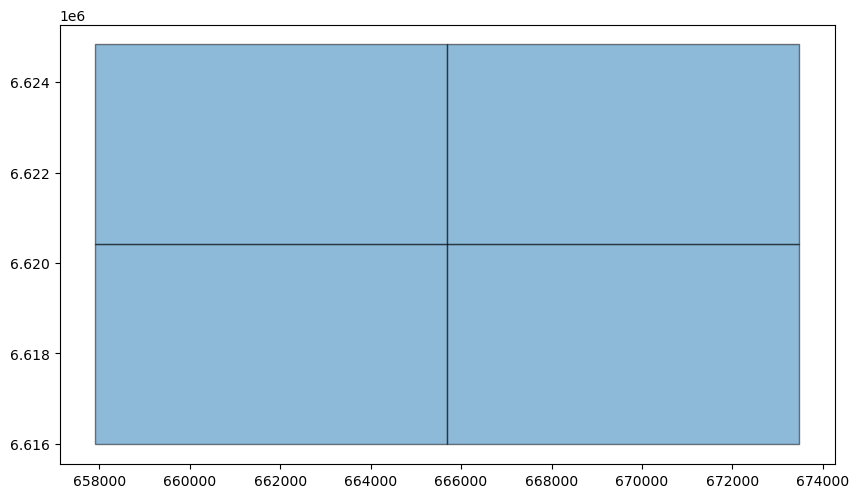

In [51]:
axes =  grid.geodataframe.to_crs(epsg=3857).plot(figsize=(10, 10), alpha=0.5, edgecolor="k")
contextily.add_basemap(axes)